In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/hindisme/DevanagariHandwrittenCharacterDataset.zip' -d '/content/drive/MyDrive/Colab Notebooks/hindisme/'

In [ ]:
# define training and test data directories
data_dir = '/content/drive/MyDrive/Colab Notebooks/hindisme/DevanagariHandwrittenCharacterDataset/'
train_dir = os.path.join(data_dir, 'Train/')
test_dir = os.path.join(data_dir, 'Test/')

In [ ]:
classes = os.listdir(train_dir)
print(len(classes))
classes

46


['character_17_tha',
 'character_18_da',
 'character_19_dha',
 'character_1_ka',
 'character_20_na',
 'character_21_pa',
 'character_22_pha',
 'character_23_ba',
 'character_24_bha',
 'character_25_ma',
 'character_26_yaw',
 'character_27_ra',
 'character_28_la',
 'character_29_waw',
 'character_2_kha',
 'character_30_motosaw',
 'character_31_petchiryakha',
 'character_32_patalosaw',
 'character_33_ha',
 'character_34_chhya',
 'character_35_tra',
 'character_36_gya',
 'character_3_ga',
 'character_4_gha',
 'character_5_kna',
 'character_6_cha',
 'character_7_chha',
 'character_8_ja',
 'character_9_jha',
 'digit_0',
 'digit_1',
 'digit_2',
 'digit_3',
 'digit_4',
 'digit_5',
 'digit_6',
 'digit_7',
 'digit_8',
 'digit_9',
 'character_10_yna',
 'character_11_taamatar',
 'character_12_thaa',
 'character_13_daa',
 'character_14_dhaa',
 'character_15_adna',
 'character_16_tabala']

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=train_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  78200
Num test images:  13800


In [ ]:
batch_size = 32
valid_size = 0.10

num_train = len(train_data)
split_point = int(valid_size * num_train)

indices = list(range(num_train))
np.random.shuffle(indices)

valid_indices = indices[:split_point]
train_indices = indices[split_point:]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
# checking batch
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([32, 3, 32, 32])

In [ ]:
# checking batch
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([32, 3, 32, 32])

In [ ]:
torch.cuda.is_available()

True

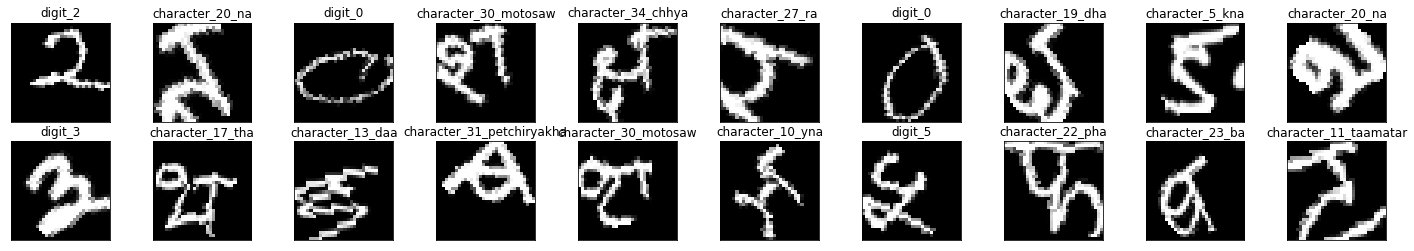

In [ ]:
 train_on_gpu = torch.cuda.is_available()
 # obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()


# plot the images in the batch, along with predicted labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    img = images.cpu()[idx]
    img = img * 0.5 + 0.5
    img = np.transpose(img, (1, 2, 0))
    # img = torchvision.transforms.ToTensor()(img)
    plt.imshow(img)
    ax.set_title(test_data.classes[labels[idx].item()])

# CNN

In [ ]:
def output(input_volume, kernel_size, padding, stride=1):
    return ((input_volume - kernel_size + 2 * padding)/stride) + 1

input_size = 32
print("Input image is of size: {}x{}".format(input_size, input_size))
print("First Conv sees: {}x{}".format(input_size, input_size))
input_size = output(input_volume=input_size, kernel_size=5, padding=0, stride=1)
print("Second Conv sees: {}x{}".format(input_size, input_size))
input_size = output(input_volume=input_size, kernel_size=5, padding=0, stride=1)
print("Third Conv sees: {}x{}".format(input_size, input_size))
input_size = output(input_volume=input_size, kernel_size=5, padding=0, stride=1)
print("Fourth Conv sees: {}x{}".format(input_size, input_size))

Input image is of size: 32x32
First Conv sees: 32x32
Second Conv sees: 28.0x28.0
Third Conv sees: 24.0x24.0
Fourth Conv sees: 20.0x20.0


In [ ]:
class Network(nn.Module):

    def __init__(self):
        super().__init__()

        # First layer sees: 32x32x3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16,
                    kernel_size=5, stride=1, padding=0)

        # Second layer sees: 28x28x16
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32,
                    kernel_size=5, stride=1, padding=0)

        # Third layer sees: 24x24x32
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64,
                    kernel_size=5, stride=1, padding=0)

        # This layer output 20 x 20 x 64

        self.fc1 = nn.Linear(20*20*64, 1000)
        self.fc2 = nn.Linear(1000, 46)
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x.view(-1, 20*20*64)

        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [ ]:
train_on_gpu = True if torch.cuda.is_available() else False
train_on_gpu

True

In [ ]:
dhcd_model = Network()

if train_on_gpu:
  print("Training on GPU...")
  dhcd_model.cuda()

Training on GPU...


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(dhcd_model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
n_epochs = 55
train_losses = []
valid_losses = []
valid_loss_min = np.inf

for e in range(n_epochs):
    train_loss = 0
    valid_loss = 0

    dhcd_model.train()

    for img, label in train_loader:

        if train_on_gpu:
            img = img.cuda()
            label = label.cuda()

        optimizer.zero_grad()

        predicted_label = dhcd_model(img)
        loss = criterion(predicted_label, label)
        loss.backward()
        optimizer.step()
        train_loss = train_loss + loss.item()

    dhcd_model.eval()

    for img, label in valid_loader:

        if train_on_gpu:
            img = img.cuda()
            label = label.cuda()
        predicted_label = dhcd_model(img)
        loss = criterion(predicted_label, label)

        valid_loss = valid_loss + loss.item()

    train_loss = train_loss/len(train_loader)
    train_losses.append(train_loss)
    valid_loss = valid_loss/len(valid_loader)
    valid_losses.append(valid_loss)

    print("Epoch: {} Train Loss: {} Valid Loss: {}".format(e+1, train_loss, valid_loss))

    if valid_loss < valid_loss_min:
        print("Validation Loss Decreased From {} to {}".format(valid_loss_min, valid_loss))
        valid_loss_min = valid_loss
        torch.save(dhcd_model.state_dict(), "dhcd_model_8_March_2020.pth")
        print("Saving Best Model")



Epoch: 1 Train Loss: 2.7598397448929872 Valid Loss: 1.6858646835599627
Validation Loss Decreased From inf to 1.6858646835599627
Saving Best Model
Epoch: 2 Train Loss: 1.3158283732966942 Valid Loss: 0.8288603165928199
Validation Loss Decreased From 1.6858646835599627 to 0.8288603165928199
Saving Best Model
Epoch: 3 Train Loss: 0.8085310150987722 Valid Loss: 0.5615909879913136
Validation Loss Decreased From 0.8288603165928199 to 0.5615909879913136
Saving Best Model
Epoch: 4 Train Loss: 0.6161744177307595 Valid Loss: 0.4758493216670289
Validation Loss Decreased From 0.5615909879913136 to 0.4758493216670289
Saving Best Model
Epoch: 5 Train Loss: 0.5087165210396052 Valid Loss: 0.3563966148361868
Validation Loss Decreased From 0.4758493216670289 to 0.3563966148361868
Saving Best Model
Epoch: 6 Train Loss: 0.4285614411312748 Valid Loss: 0.3289354109642457
Validation Loss Decreased From 0.3563966148361868 to 0.3289354109642457
Saving Best Model
Epoch: 7 Train Loss: 0.386881397373297 Valid Loss

In [ ]:
torch.save(dhcd_model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/hindisme/model_98.pt")

In [ ]:
dhcd_model.load_state_dict(torch.load("dhcd_model_8_March_2020.pth"))

<All keys matched successfully>

In [ ]:
torch.save(dhcd_model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/hindisme/model_best84.pt")

In [ ]:
n_epochs = 50
avg_accuracy = 0
total_accuracy = 0
test_loss = 0
accuracy = 0
dhcd_model.eval()

for epoch in range(n_epochs):

    for img, label in test_loader:
        if train_on_gpu:
            img = img.cuda()
            label = label.cuda()
        predicted_label = dhcd_model(img)
        loss = criterion(predicted_label, label)
        test_loss = test_loss + loss.item()

        top_probab, top_label = predicted_label.topk(1, dim=1)
        equals = top_label == label.view(*top_label.shape)
        accuracy = accuracy + torch.mean(equals.type(torch.FloatTensor))

    test_loss = test_loss/len(test_loader)
    accuracy = accuracy/len(test_loader)
    total_accuracy = total_accuracy + accuracy

    print("Epoch: {} Test Loss: {} Accuracy: {}".format(epoch+1, test_loss, accuracy))

avg_accuracy = total_accuracy/(n_epochs) * 100
print("______________________\nAverage Accuracy: {:.3f}%\n______________________".format(avg_accuracy))

Epoch: 1 Test Loss: 0.09512086537735606 Accuracy: 0.9704861044883728
Epoch: 2 Test Loss: 0.08639978362984804 Accuracy: 0.9770728945732117
Epoch: 3 Test Loss: 0.09575039095839864 Accuracy: 0.9736159443855286
Epoch: 4 Test Loss: 0.08730427612836235 Accuracy: 0.9769355058670044
Epoch: 5 Test Loss: 0.09488927255920337 Accuracy: 0.9742665886878967
Epoch: 6 Test Loss: 0.09196655796963832 Accuracy: 0.9736817479133606
Epoch: 7 Test Loss: 0.09549767536335668 Accuracy: 0.9731017351150513
Epoch: 8 Test Loss: 0.08697483851602907 Accuracy: 0.9751980900764465
Epoch: 9 Test Loss: 0.0905381959040561 Accuracy: 0.974841296672821
Epoch: 10 Test Loss: 0.08918680040609173 Accuracy: 0.9770829677581787
Epoch: 11 Test Loss: 0.09485485181343341 Accuracy: 0.9736882448196411
Epoch: 12 Test Loss: 0.0950339435891891 Accuracy: 0.9746208190917969
Epoch: 13 Test Loss: 0.0818597325041523 Accuracy: 0.9765037298202515
Epoch: 14 Test Loss: 0.09197546769426396 Accuracy: 0.9752060174942017
Epoch: 15 Test Loss: 0.0831490928

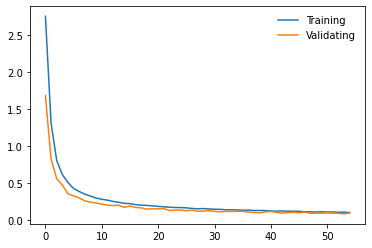

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1)
axes.plot(train_losses, label="Training")
axes.plot(valid_losses, label="Validating")
axes.legend(frameon=False)

In [ ]:
print('train : ')
print(train_losses)
print('val : ')
print(valid_losses)

train : 
[2.7598397448929872, 1.3158283732966942, 0.8085310150987722, 0.6161744177307595, 0.5087165210396052, 0.4285614411312748, 0.386881397373297, 0.35141669418493454, 0.3253875556029379, 0.2984139580216089, 0.28276405520652503, 0.27063644166231493, 0.2536855847964233, 0.24140651995908807, 0.2273884801867164, 0.22319921146612615, 0.21057269558966668, 0.20176184849707748, 0.2001149293365465, 0.1916395331963643, 0.18637493783163583, 0.18036244991044936, 0.17475536490917545, 0.17095515880088152, 0.1706245566862212, 0.16619105435071768, 0.15852913199606436, 0.15348141349576921, 0.15681805626108228, 0.1515202038957928, 0.1474803960096853, 0.14607652637022758, 0.14035450612522915, 0.14065977999834683, 0.1382118754973635, 0.134594165335875, 0.13606015333366073, 0.1302599419130605, 0.13125693771966987, 0.12954248020838185, 0.12373979991471226, 0.1208577755055475, 0.12493056443138895, 0.1200655867532954, 0.12048255149243314, 0.11985330994627227, 0.11257814660287377, 0.11341925078537315, 0.110

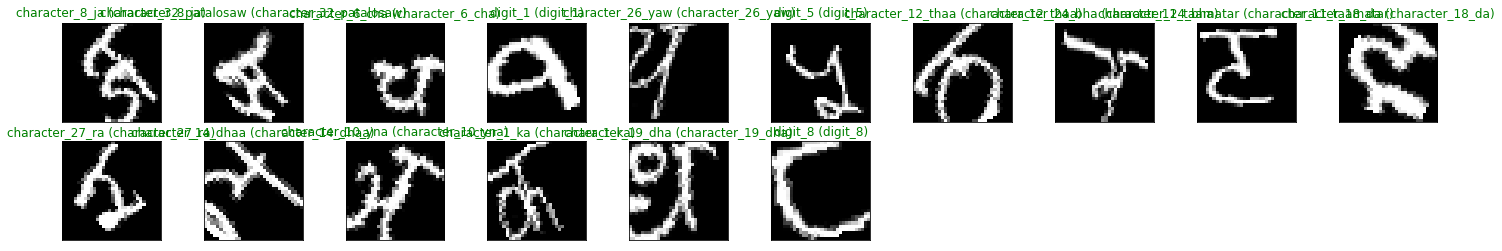

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = dhcd_model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(
    preds_tensor.numpy()) if not train_on_gpu else np.squeeze(
         preds_tensor.cpu().numpy())



# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    img = images.cpu()[idx]
    img = img * 0.5 + 0.5
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    ax.set_title("{} ({})".format(train_data.classes[preds[idx].item()],
                train_data.classes[labels[idx].item()]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
images = images.cuda()

# get sample outputs
output = dhcd_model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
# preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().detach().numpy())
preds = preds_tensor.cpu().detach().numpy()

preds

array([31, 33, 30, 31, 45, 21, 19, 14, 18, 43,  0,  3,  9, 17, 28, 40, 44,
       25, 40, 33, 38, 21,  1, 20, 44, 38, 31, 10, 25, 20, 14, 25])

In [ ]:
yes = 0
no = 0
for i in range(len(preds)):
    print(classes[preds[i]], classes[labels[i]])
    if (classes[preds[i]] == classes[labels[i]]):
        yes+=1
    else:
        no+=1

print(yes,no)

character_5_kna character_5_kna
character_7_chha character_7_chha
character_4_gha character_4_gha
character_5_kna character_5_kna
digit_9 digit_9
character_2_kha character_2_kha
character_28_la character_28_la
character_23_ba character_23_ba
character_27_ra character_27_ra
digit_7 digit_7
character_10_yna character_10_yna
character_13_daa character_5_kna
character_19_dha character_19_dha
character_26_yaw character_26_yaw
character_36_gya character_36_gya
digit_4 digit_4
digit_8 digit_8
character_33_ha character_33_ha
digit_4 digit_4
character_7_chha character_7_chha
digit_2 digit_2
character_2_kha character_2_kha
character_11_taamatar character_11_taamatar
character_29_waw character_29_waw
digit_8 digit_8
digit_2 digit_2
character_5_kna character_5_kna
character_1_ka character_1_ka
character_33_ha character_33_ha
character_29_waw character_29_waw
character_23_ba character_33_ha
character_33_ha character_33_ha
30 2


## NEW

In [ ]:
# torch.save(dhcd_model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/hindisme/model_best84.pt")
dhcd_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/hindisme/model_best84.pt"))

<All keys matched successfully>

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

images[0].shape

torch.Size([3, 32, 32])

In [ ]:
# pth = '/content/drive/MyDrive/Colab Notebooks/hindisme/DevanagariHandwrittenCharacterDataset/Test/character_14_dhaa/10721.png'
pth = '/content/drive/MyDrive/Colab Notebooks/hindisme/invertdemo.png'
# pth = '/content/drive/MyDrive/Colab Notebooks/hindisme/DevanagariHandwrittenCharacterDataset/Test/digit_4/103744.png'
from PIL import Image
def pil_loader(pth):
  with open(pth, 'rb') as f:
    with Image.open(f) as img:
      return img.convert('RGB')

img = pil_loader(pth)
img

In [ ]:
tfms =  transforms.Compose([
        transforms.Scale((32,32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5))])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
img_tensor = tfms(img).to('cuda').unsqueeze(0)

img_tensor[0].shape

torch.Size([3, 32, 32])

In [ ]:
if train_on_gpu:
    img_tensor = img_tensor.cuda()

# get sample outputs
output = dhcd_model(img_tensor)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

In [ ]:
test_data.classes

['character_10_yna',
 'character_11_taamatar',
 'character_12_thaa',
 'character_13_daa',
 'character_14_dhaa',
 'character_15_adna',
 'character_16_tabala',
 'character_17_tha',
 'character_18_da',
 'character_19_dha',
 'character_1_ka',
 'character_20_na',
 'character_21_pa',
 'character_22_pha',
 'character_23_ba',
 'character_24_bha',
 'character_25_ma',
 'character_26_yaw',
 'character_27_ra',
 'character_28_la',
 'character_29_waw',
 'character_2_kha',
 'character_30_motosaw',
 'character_31_petchiryakha',
 'character_32_patalosaw',
 'character_33_ha',
 'character_34_chhya',
 'character_35_tra',
 'character_36_gya',
 'character_3_ga',
 'character_4_gha',
 'character_5_kna',
 'character_6_cha',
 'character_7_chha',
 'character_8_ja',
 'character_9_jha',
 'digit_0',
 'digit_1',
 'digit_2',
 'digit_3',
 'digit_4',
 'digit_5',
 'digit_6',
 'digit_7',
 'digit_8',
 'digit_9']

In [ ]:
test_data.classes[preds_tensor[0]]

'character_19_dha'